In [1]:
# General Dependencies
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils.noise import estimate_noise

# CPP Wrapper Dependencies
from trefide.pmd import batch_decompose, batch_recompose

# Experimental Implementation Dependencies
from trefide.temporal import TrendFilter
from trefide.utils.greedyPCA import choose_rank

# Plotting & Video Dependencies
import matplotlib.pyplot as plt
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imshow

%load_ext autoreload
%autoreload 2

# functions to migrate

In [2]:
def eval_tv(image):
    return np.sum(np.abs(image[1:,:] - image[:-1,:])) + np.sum(np.abs(image[:,1:] - image[:,:-1]))

In [3]:
def play(movie, gain=3, fr=120, offset=0, magnification=3):
    maxmov = np.max(movie)
    looping=True
    terminated=False
    while looping:
        for t in range(350, 1000):
            if magnification != 1:
                frame = cv2.resize(movie[:,:,t],
                                   None,
                                   fx=magnification,
                                   fy=magnification,
                                   interpolation=cv2.INTER_LINEAR)
            imshow('frame', (frame - offset) / maxmov*gain)
            if cv2.waitKey(int(1. / fr * 1000)) & 0xFF == ord('q'):
                looping = False
                terminated = True
                break
        if terminated:
            break

    cv2.waitKey(100)
    cv2.destroyAllWindows()
    for i in range(10):
        cv2.waitKey(100)

# Load Data & Set Params

In [4]:
X = np.load("../data/prepared_sampleMovie.npy")
d1, d2, T = X.shape

In [5]:
max_components = 20
maxiter=50
tol = 5e-3
bheight = 40
bwidth = 40
spatial_cutoff = (bheight*bwidth / ((bheight*(bwidth-1) + bwidth*(bheight-1))))
w=.0025

# Decompose In Parallel

In [6]:
U, V, K, indices = batch_decompose(d1, d2, T, X, bheight, bwidth, w, spatial_cutoff, max_components, maxiter, tol)

In [7]:
K

array([1, 5, 3, 4, 2, 4, 2, 2, 2, 2, 5, 4, 6, 5, 7, 8, 3, 5, 4, 4, 6, 3,
       4, 2, 3, 3, 3, 2, 2, 6, 6, 3, 5, 2, 4, 3, 3, 3, 1, 3], dtype=uint64)

# Evaluate Processing Time

In [8]:
import timeit
def time_pmd():
    U, V, K, indices = batch_decompose(d1, d2, T, X, bheight, bwidth, w, spatial_cutoff, max_components, maxiter, tol)

In [9]:
timeit.timeit(time_pmd, number=5)/5

9.67582289139973

# Test Temporal Components

# Inspect Results

## Plots

### Patch Ranks

In [10]:
# TODO MAKE PLOT
K

array([1, 5, 3, 4, 2, 4, 2, 2, 2, 2, 5, 4, 6, 5, 7, 8, 3, 5, 4, 4, 6, 3,
       4, 2, 3, 3, 3, 2, 2, 6, 6, 3, 5, 2, 4, 3, 3, 3, 1, 3], dtype=uint64)

### Component Quality

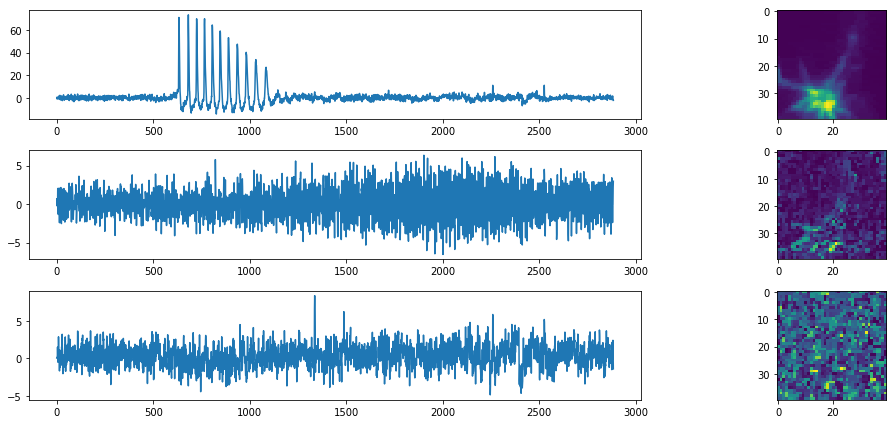

In [11]:
b_idx = -1
fig, ax = plt.subplots(int(K[b_idx]), 2, figsize=(16, 2*int(K[b_idx])))
for k in range(int(K[b_idx])):
    ax[k,0].plot(np.arange(T), V[b_idx, k, :])
    ax[k,1].imshow(np.abs(U[b_idx,:,:,k]))
    #ax[k,0].set_title("Temporal component {}, Passed: {}".format(k, not k in temporal_failed))
    #ax[k,1].set_title("Spatial component {}, Passed: {}".format(k,k < K_prev[b_idx]))
plt.tight_layout()
plt.show()

### Correlation Plots

## Videos

### Full Movie

In [12]:
reconstructed = batch_recompose(U,V,K, indices)

In [13]:
play(np.vstack([X, reconstructed, X - reconstructed]), magnification=2)

### Single Patch

In [14]:
b_idx = 0
idx, jdx = int(indices[b_idx,0]), int(indices[b_idx,1])
denoised = reconstructed[idx:idx+bheight, jdx:jdx+bwidth]
raw = X[idx:idx+bheight, jdx:jdx+bwidth]
residual = raw - denoised
play(np.vstack([raw, denoised, residual]), magnification=7)